# `flarestack` Test Minimization Notebook

## 1. Directory Setup

In [1]:
import logging
logging.basicConfig(level='INFO')

In [2]:
import os
os.environ['FLARESTACK_SCRATCH_DIR']

'/Users/thomasahrens/Desktop/IceCube/flarestack/scratch'

In [3]:
from flarestack.shared import host_server
from flarestack.data.icecube.ic_season import icecube_dataset_dir
print(f'Running at {host_server}, data directory is {icecube_dataset_dir}')

INFO:flarestack.shared:Scratch Directory is: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/
INFO:flarestack.shared:Found Directory: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/
INFO:flarestack.shared:Found Directory: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/input/
INFO:flarestack.shared:Found Directory: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/storage/
INFO:flarestack.shared:Found Directory: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/output/
INFO:flarestack.shared:Found Directory: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/cluster/
INFO:flarestack.shared:Found Directory: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/input/pull_corrections/
INFO:flarestack.shared:Found Directory: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/cluster/logs/
INFO:flarestack.shared:Fou

Running at None, data directory is /Users/thomasahrens/Desktop/IceCube/flarestack/datasets/


In [4]:
from flarestack.shared import fs_scratch_dir
print(f'Scratch directory is {fs_scratch_dir}')

Scratch directory is /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/


## 2. Flarestack Classes

Classes used in $\texttt{flarestack}$'s core functionality (e.g. `flarestack.core.energy_pdf.EnergyPDF`, `flarestack.core.minimisation.MinimisationHandler`, etc) have a class attribute `<class>.subclasses`.  
This is a dictionary with the structure `{<subclass name>: <subclass>}`.  

In [5]:
from flarestack.core.minimisation import MinimisationHandler
MinimisationHandler.subclasses

{'fixed_weights': flarestack.core.minimisation.FixedWeightMinimisationHandler,
 'large_catalogue': flarestack.core.minimisation.LargeCatalogueMinimisationHandler,
 'fit_weights': flarestack.core.minimisation.FitWeightMinimisationHandler,
 'fit_weights_mcmc': flarestack.core.minimisation.FitWeightMCMCMinimisationHandler,
 'fit_weights_hmc': flarestack.core.minimisation.FitWeightHMCMinimisationHandler,
 'flare': flarestack.core.minimisation.FlareMinimisationHandler}

For analyses we only have to pass a dictionary of the subclass names and corresponding parameters.  
To execute use `flarestack.cluster.submitter.Submitter`. This always works locally. For using the cluster, again, if you are running at DESY or WIPAC, you do not have to worry. We got you covered.

In [6]:
from flarestack.cluster.submitter import Submitter
Submitter.submitter_dict

{'local': flarestack.cluster.submitter.LocalSubmitter,
 'DESY': flarestack.cluster.submitter.DESYSubmitter,
 'WIPAC': flarestack.cluster.submitter.WIPACSubmitter}

## 3. Example: Point Source Sensitivity

Let's try to calculate the 10-year point source sensitivity for our test catalogue.  
The input directory (with the analysis dictionaries), the output directory (plots, p-values, etc) and the cache directory (saved trials, etc) will be created accordingly.   
First we have to specify a name for the analysis.

In [7]:
from flarestack.shared import plot_output_dir, name_pickle_output_dir
from glob import glob

In [8]:
min_types = ('fixed',  # fixed_weights
             'fit',    # fit_weights
             'mcmc',   # fit_weights_mcmc
             'hmc')    # NotImplemented

def name_func(n_sources, gamma, min_type, scale, trials, etc=None):
    """Creates name for output analysis files. This is motivated
    by the need to inspect run results for debugging purposes, 
    and is achieved by using unique names to refer to each run.
    
    :param n_sources: Number of sources in catalog
    :type n_sources: int
    
    :param gamma: Spectral index
    :type n_sources: float
    
    :param min_type: Minimization method (see MinimisationHandler.subclasses)
    :type n_sources: str
    
    :param etc: Additional simulation/run info
    :type n_sources: str
    
    :return path: Path used as name
    :rtype path: str
    """
    run_no = 1
    
    if min_type not in min_types:
        raise ValueError(f'Provide valid minimizer: {min_types}')
        
    path = f'analyses/{n_sources}source_gamma{gamma}_{min_type}_{scale}_trials{trials}'
    
    if etc is not None:
        path += f'_{etc:s}'
        
    path += f'_run{run_no}'
    
    path_exist = os.path.exists(plot_output_dir(path)) or os.path.exists(name_pickle_output_dir(path))
    
    if path_exist:
        # Automatically covers cases where run_no == (n_sources or gamma)
        glob_path = path.split(f'_run{run_no}')[0]
        # Get all runs with same path
        previous_runs = glob(f'{name_pickle_output_dir(glob_path)}*')
        # Get run numbers for previous runs, convert strings to ints
        run_nums = [int(i.split('_run')[1]) for i in previous_runs]
        # Sort run numbers
        run_nums.sort()
        # Get last run number, increase index by 1
        run_no = run_nums[-1] + 1
        path = f'{glob_path}_run{run_no}'
    else:
        # Path DNE, unchanged path (run 1)
        pass
    
    return path

In [9]:
name = name_func(n_sources=2, gamma=2.0, min_type='fit', 
                 scale='sumscale', trials=10, etc='allseasons')
name

'analyses/2source_gamma2.0_fit_sumscale_trials10_allseasons_run4'

Our plot output directories will be:

In [10]:
from flarestack.shared import plot_output_dir, name_pickle_output_dir
plot_output_dir(name), name_pickle_output_dir(name)

('/Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/output/plots/analyses/2source_gamma2.0_fit_sumscale_trials10_allseasons_run4',
 '/Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/storage/pickles/analyses/2source_gamma2.0_fit_sumscale_trials10_allseasons_run4')

Public 3-year point source data.

In [11]:
# from flarestack.data.icecube import ps_v003_p02
from flarestack.data.public import icecube_ps_3_year

for item in icecube_ps_3_year.items():
    print(item)

('IC79-2010', <flarestack.data.public.icecube.PublicICSeason object at 0x17ad76050>)
('IC86-2011', <flarestack.data.public.icecube.PublicICSeason object at 0x17ad75db0>)
('IC86-2012', <flarestack.data.public.icecube.PublicICSeason object at 0x17ad75870>)


We want to inject a steady neutrino signal with a power law spectrum with $\gamma=2.5$. For other Energy or Time PDFs check `flarestack.core.energy_pdf` and `flarestack.core.time_pdf`.   \
This is as straight forward as:

In [12]:
injection_energy = {
    "energy_pdf_name": "power_law",
    "gamma": 2.0
}

injection_time = {
    "time_pdf_name": "steady"
}

inj_kwargs = {
    "injection_energy_pdf": injection_energy,
    "injection_sig_time_pdf": injection_time
}

We are looking for a steady signal with a power law spectrum. 
We assume the background to be constant in time.  
We want to use the "standard" point source likelihood. More likelihood implementations in `flarestack.core.llh`

In [13]:
llh_time = {
    "time_pdf_name": "steady"
}

llh_energy = {
    "energy_pdf_name": "power_law",
}

llh_time_bkg = {
    "time_pdf_name": "steady"
}

llh_kwargs = {
    "llh_name": "standard",
    "llh_energy_pdf": llh_energy,
    "llh_sig_time_pdf": llh_time,
    "llh_bkg_time_pdf": llh_time_bkg
}

We need a source catalogue. This catalogue will be a numpy array stored as a `.npy` file and we only pass the filename.   
For point sources the is a uitility function to generate dummy sources.

In [14]:
# from flarestack.utils.prepare_catalogue import ps_catalogue_name
import numpy as np

sindec = 0.5
catalogue_path = "/Users/thomasahrens/Desktop/IceCube/sn-search/catalog/test_catalogue_2.npy"
print(f'your catalogue is located at {catalogue_path}')
catalogue = np.load(catalogue_path)
catalogue

your catalogue is located at /Users/thomasahrens/Desktop/IceCube/sn-search/catalog/test_catalogue_2.npy


array([(0.19872028, -0.24886844, 1., 1., nan, nan, nan, 2.04324986e+13, b'ASASSN-14il'),
       (3.67889954, -0.67152028, 1., 1., nan, nan, nan, 1.64885347e+13, b'ASASSN-15ab')],
      dtype=[('ra_rad', '<f8'), ('dec_rad', '<f8'), ('base_weight', '<f8'), ('injection_weight_modifier', '<f8'), ('ref_time_mjd', '<f8'), ('start_time_mjd', '<f8'), ('end_time_mjd', '<f8'), ('distance_mpc', '<f8'), ('source_name', 'S30')])

Now we make a guess for our sensitivity.   
Note: $\texttt{flarestack}$ is using its own scale factor $k$.

In [15]:
from flarestack.shared import flux_to_k, k_to_flux
flux_to_k(1), flux_to_k(1e-9)

(999999999.9999999, 1.0)

Here we know where the sensitivity should be. Because the analysis has been done before.

In [16]:
logging.basicConfig(level='ERROR')
from flarestack.icecube_utils.reference_sensitivity import reference_sensitivity
scale = flux_to_k(reference_sensitivity(np.sin(catalogue['dec_rad']))) * 3
scale

array([ 6.24859081, 24.92108471])

Now we just have to put all the info into one dictionary to pass to the `MinimisationHandler`. Note that our scale guess is informed by the sum over the estimated scales from `flarestack.icecube_utils.reference_sensitivity`. 

In [ ]:
mh_dict = {
    "name": name,                                           # unique name for the analysis
    "mh_name": "fit_weights",                               # name of the MinimisationHandler subclass
    "dataset": icecube_ps_3_year.get_seasons(),             # the neutrino dataset
    "catalogue": catalogue_path,                            # path to the .npy catalogue file
    "inj_dict": inj_kwargs,                                 # info for the Injector
    "llh_dict": llh_kwargs,                                 # info for the LLH
    "scale": np.sum(scale),                                 # a guess for the sensitivity scale
    "n_trials": 10,                                         # number of trials to run (background trials will be run ten times this number!)
    "n_steps": 10,                                          # number of steps when injecting signal
    "allow_extrapolated_sensitivity": True                  # allow extrapolation in the sensitivity calculation (here we do because we only run very few trials)
}

To execute the analysis we defined above we create a submitter instance

In [ ]:
submitter = Submitter.get_submitter(
    mh_dict=mh_dict,                         # the analysis info
    use_cluster=False,                       # run it on the cluster if True
    n_cpu=7,                                # number of LOCAL CPUs to use, NOTE: the number of cluster CPUs has to be specified in the cluster_kwargs!
    do_sensitivity_scale_estimation=False,   # make a guess of the sensitivity scale, for options check flarestack.cluster.submitter
    remove_old_results=True,                 # if you are running the analysis again and something changed, maybe you want to remove old trials?
#   **cluster_kwargs                         # keyword arguments used when running the cluster, This depends on the cluster obviously
)

print(submitter)

Energise ......

In [ ]:
submitter.analyse()

To get the results we use the `ResultsHandler()`. This will also create some plots like the sensitivity fit, bias plots, etc. in the plot directory. If `OverfluctuationError`, set `do_sens=False` and `do_disc=False` in `ResultsHandler()` object.

```do_sens=False, do_disc=False```

In [ ]:
from flarestack.core.results import ResultsHandler
results_handler = ResultsHandler(submitter.mh_dict)

In [ ]:
print(fr'sensitivity flux: {results_handler.sensitivity:<10.2e} '
      fr'+{results_handler.sensitivity_err[1]:<10.2e} '
      fr'-{results_handler.sensitivity_err[0]:<10.2e}')
print(f'reference: {reference_sensitivity(sindec)[0]:>15.2e}')
print(fr'sensitivity n_s:  {results_handler.sensitivity * results_handler.flux_to_ns:<10.2e} '
      fr'+{results_handler.sensitivity_err[1] * results_handler.flux_to_ns:<9.4f}  '
      fr'-{results_handler.sensitivity_err[0] * results_handler.flux_to_ns:<9.4f}')

# Repeat analysis using MCMC
`n_trials` has been reduced in order to run this notebook more easily, `n_trials = 100` has been used for testing purposes.

### Find MCMC seed values

Seed the MCMC around the maximum LLH fround by the `fit_weights` minimizer. Copy `mu` and `std` lists into MCMC minimizer class.

In [ ]:
from glob import glob
import pickle

In [ ]:
def means_and_dev(name):
    """Calculates mean and standard deviation from `fit_weights` minimizer
    to then be input into `fit_weights_mcmc` minimizer.
    
    :param name: Analysis run name
    :type name: str
    
    :return mu: List of average parameter (n_s, gamma) values
    :rtype mu: list
    
    :return std: List of parameter (n_s, gamma) standard deviations
    :rtype std: list
    """
    path_to_pickles = os.path.join(name_pickle_output_dir(name), 'merged')
    pickles = glob(os.path.join(path_to_pickles, '*.pkl'))
    key_arrays = {}
    
    for pkl in pickles:
        pickle_path = pkl

        with open(pickle_path, 'rb') as file:
            pickle_data = pickle.load(file)

        if not key_arrays:
            key_arrays = {key:[] for key in pickle_data['Parameters'].keys()}

        for key, data in pickle_data['Parameters'].items():
                key_arrays[key].append(data)
        
    mu = []
    std = []

    for key, data in key_arrays.items():
        key_arrays[key] = np.array(sum(key_arrays[key], []))
        mu.append(float(f'{np.mean(key_arrays[key]):0.4f}'))
        std.append(float(f'{np.std(key_arrays[key]):0.4f}'))

    print(f"mu = {mu}")
    print(f"std = {std}")

In [ ]:
means_and_dev(name)

### Setup MCMC

In [17]:
name = name_func(n_sources=2, gamma=2.0, min_type='mcmc', 
                 scale='sumscale', trials=10, etc='allseasons')
name

'analyses/2source_gamma2.0_mcmc_sumscale_trials10_allseasons_run3'

In [18]:
mh_dict = {
    "name": name,                                           # unique name for the analysis
    "mh_name": "fit_weights_mcmc",                          # name of the MinimisationHandler subclass
    "dataset": icecube_ps_3_year.get_seasons(),  # the neutrino dataset
    "catalogue": catalogue_path,                            # path to the .npy catalogue file
    "inj_dict": inj_kwargs,                                 # info for the Injector
    "llh_dict": llh_kwargs,                                 # info for the LLH
    "scale": np.sum(scale),                                 # a guess for the sensitivity scale
    "n_trials": 10,                                         # number of trials to run (background trials will be run ten times this number!)
    "n_steps": 10,                                          # number of steps when injecting signal
    "allow_extrapolated_sensitivity": True                  # allow extrapolation in the sensitivity calculation (here we do because we only run very few trials)
}

In [19]:
submitter = Submitter.get_submitter(
    mh_dict=mh_dict,                         # the analysis info
    use_cluster=False,                       # run it on the cluster if True
    n_cpu=7,                                # number of LOCAL CPUs to use, NOTE: the number of cluster CPUs has to be specified in the cluster_kwargs!
    do_sensitivity_scale_estimation=False,   # make a guess of the sensitivity scale, for options check flarestack.cluster.submitter
    remove_old_results=True,                 # if you are running the analysis again and something changed, maybe you want to remove old trials?
#   **cluster_kwargs                         # keyword arguments used when running the cluster, This depends on the cluster obviously
)

print(submitter)


----- Submitter for analyses/2source_gamma2.0_mcmc_sumscale_trials10_allseasons_run3 -----
not using cluster 
using 7 CPUs locally
job-id: None 
no scale estimation 



In [20]:
submitter.analyse()

INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.injector:Initialising Injector for IC79-2010
INFO:flarestack.core.injector:Initialising Injector for IC86-2011
INFO:flarestack.core.injector:Initialising Injector for IC86-2012
INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.multiprocess_wrapper:Added 190 trials to queue. Now processing.
INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.multiprocess_wrapper:190 tasks remaining.
INFO:flarestack.core.minimisation:Using 'standard' LLH class
/Users/thomasahrens/Desktop/IceCube/flarestack/flarestack/core/llh.py:912: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a lis

INFO:flarestack.core.multiprocess_wrapper:138 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:136 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:135 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:134 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:132 tasks remaining.
/Users/thomasahrens/opt/anaconda3/envs/hesnu/lib/python3.10/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]
INFO:flarestack.core.multiprocess_wrapper:130 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:127 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:125 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:124 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:122 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:119 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:117 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:115 tasks remaining.
INFO:flarest

In [21]:
from flarestack.core.results import ResultsHandler
results_handler_mcmc = ResultsHandler(submitter.mh_dict)

INFO:flarestack.core.results:Saving bias plot to /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/output/plots/analyses/2source_gamma2.0_mcmc_sumscale_trials10_allseasons_run3/bias_n_s (b'ASASSN-15ab').pdf
INFO:flarestack.core.results:Saving bias plot to /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/output/plots/analyses/2source_gamma2.0_mcmc_sumscale_trials10_allseasons_run3/bias_n_s (b'ASASSN-14il').pdf
INFO:flarestack.core.results:Saving bias plot to /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/output/plots/analyses/2source_gamma2.0_mcmc_sumscale_trials10_allseasons_run3/bias_gamma.pdf
INFO:flarestack.core.results:Fraction of overfluctuations is 0.50 above 0.04 (N_trials=100) (Scale=0)
INFO:flarestack.core.results:Fraction of overfluctuations is 0.70 above 0.04 (N_trials=10) (Scale=3.463)
INFO:flarestack.core.results:Fraction of overfluctuations is 1.00 above 0.04 (N_trials=10) (Scale=6.927)
INFO:flarestack.

In [22]:
print(fr'sensitivity flux: {results_handler_mcmc.sensitivity:<10.2e} '
      fr'+{results_handler_mcmc.sensitivity_err[1]:<10.2e} '
      fr'-{results_handler_mcmc.sensitivity_err[0]:<10.2e}')
print(f'reference: {reference_sensitivity(sindec)[0]:>15.2e}')
print(fr'sensitivity n_s:  {results_handler_mcmc.sensitivity * results_handler_mcmc.flux_to_ns:<10.2e} '
      fr'+{results_handler_mcmc.sensitivity_err[1] * results_handler_mcmc.flux_to_ns:<9.4f}  '
      fr'-{results_handler_mcmc.sensitivity_err[0] * results_handler_mcmc.flux_to_ns:<9.4f}')

sensitivity flux: 6.30e-09   +-3.64e-08  -3.45e-09  
reference:        5.77e-10
sensitivity n_s:  3.01e+00   +-17.3845   -1.6465   


## 4. MCMC Analysis Plots

In [23]:
import pickle
import corner
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [24]:
mpl.rcParams['figure.dpi'] = 300

In [25]:
mcmc_pickle_path = os.path.join(name_pickle_output_dir(name), 'chains.pkl')

with open(mcmc_pickle_path, 'rb') as file:
    mcmc_pickle = pickle.load(file)
    
mcmc_pickle.shape

(9910, 25, 3)

In [26]:
def labels(name):
    corner_labels = []
    for source in range(len(catalogue)):
        corner_label = catalogue[source]['source_name'].decode()
        corner_labels.append('n_s: ' + corner_label)
    corner_labels.append('gamma')
    
    return corner_labels

### Corner Plot

In [27]:
def corner_plot(name, save_fig=False, **kwargs):
    
    corner_labels = labels(name)

    truths = np.append(scale / 3, injection_energy['gamma'])
    
    corner_kwargs = dict(
        bins=30,
        labels=corner_labels,
        quantiles=[0.16, 0.5, 0.84],
        truths=truths,
        use_math_text=True,
        show_titles=True, 
        title_kwargs={"fontsize": 10},
        truth_color='#4682b4',
        plot_datapoints=False, 
        fill_contours=True,
    )
    
    for key, value in kwargs.items():
        corner_kwargs[key] = value
    
    ndim = len(catalogue) + 1
    
    reshaped_steps = mcmc_pickle.reshape((-1,ndim))
    
    fig = corner.corner(reshaped_steps, 
                        **corner_kwargs)
    
    if save_fig:
        plt.savefig(os.path.join(plot_output_dir(name), 'corner.png'))

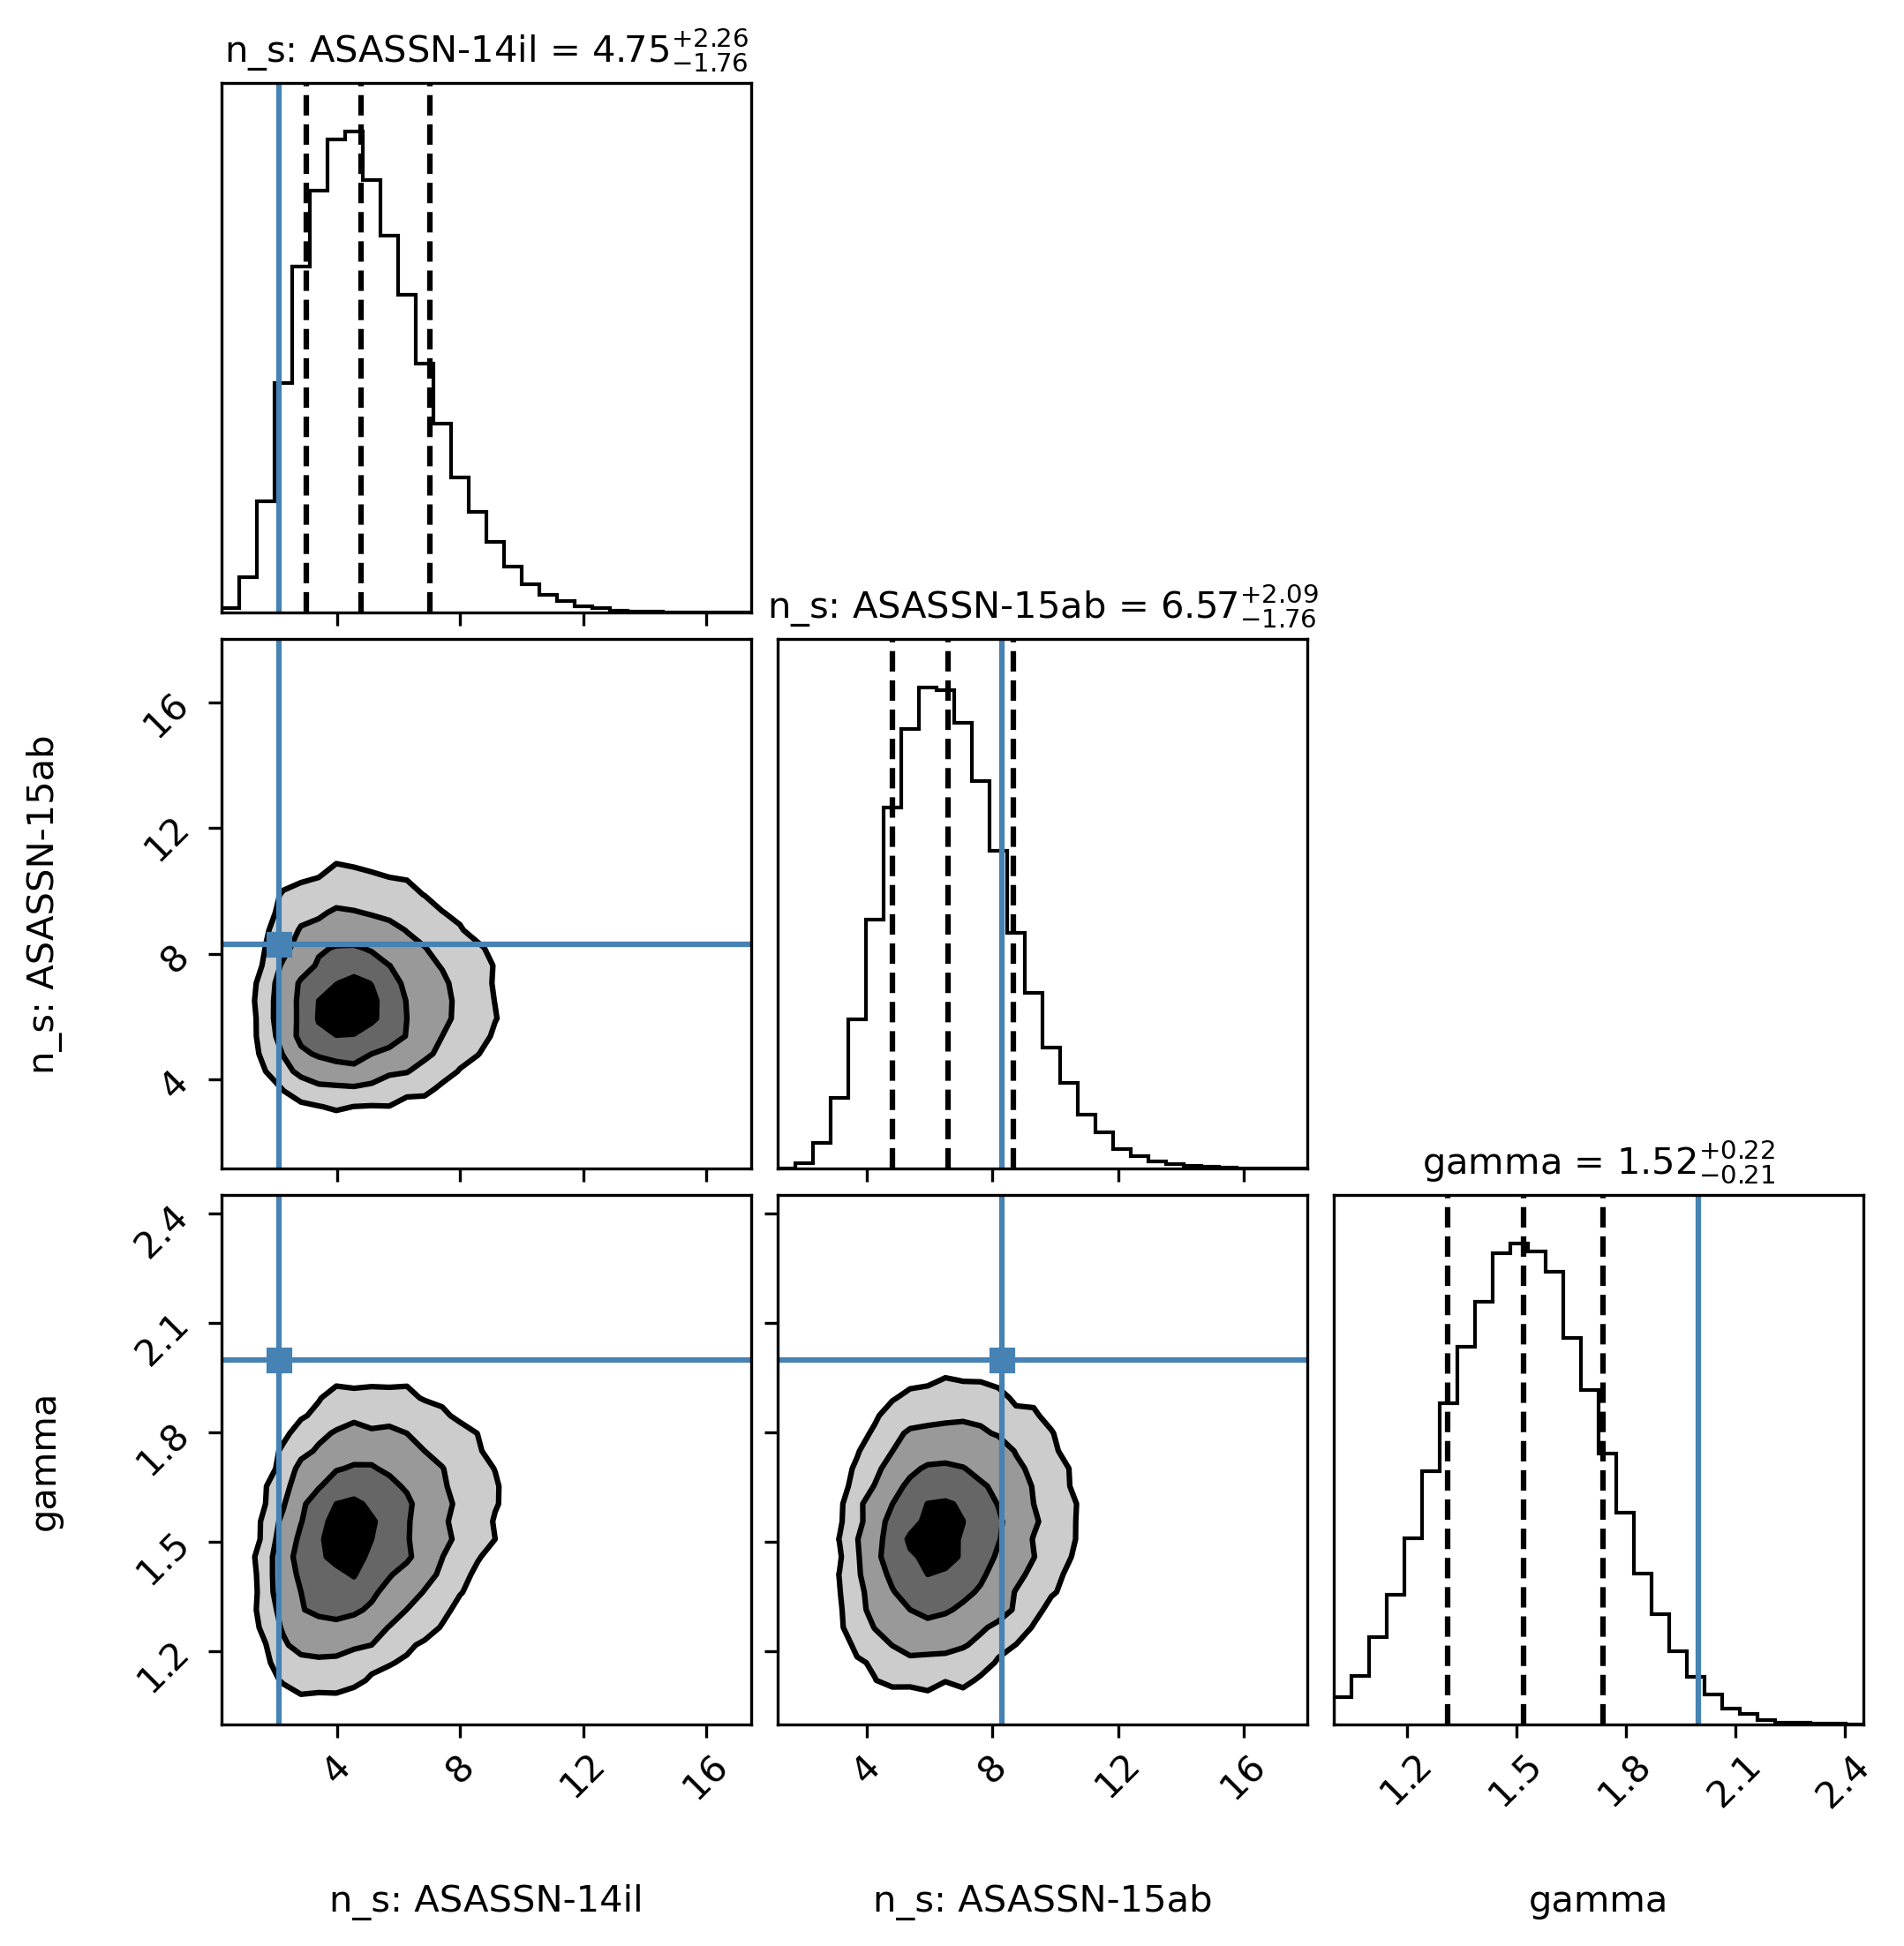

In [28]:
corner_plot(name, save_fig=True)

### Walker Steps

In [29]:
def walker_plot(name, n_steps=len(mcmc_pickle), save_fig=False):
    ndim = len(catalogue) + 1
    fig, axes = plt.subplots(ndim, figsize=(15, 8), sharex=True)
    # samples = sampler.get_chain()
    walker_labels = labels(name)
    for i in range(ndim):
        ax = axes[i]
        ax.plot(mcmc_pickle[:, :, i], "k", alpha=0.1)
        ax.set_xlim(0, len(mcmc_pickle[:n_steps]))
        ax.set_ylabel(walker_labels[i], rotation=0, ha='right')
        ax.yaxis.set_label_coords(-0.05, 0.5)

    axes[-1].set_xlabel("step number")
    fig.tight_layout
    
    if save_fig:
        plt.savefig(os.path.join(plot_output_dir(name), 'walkers.png'))

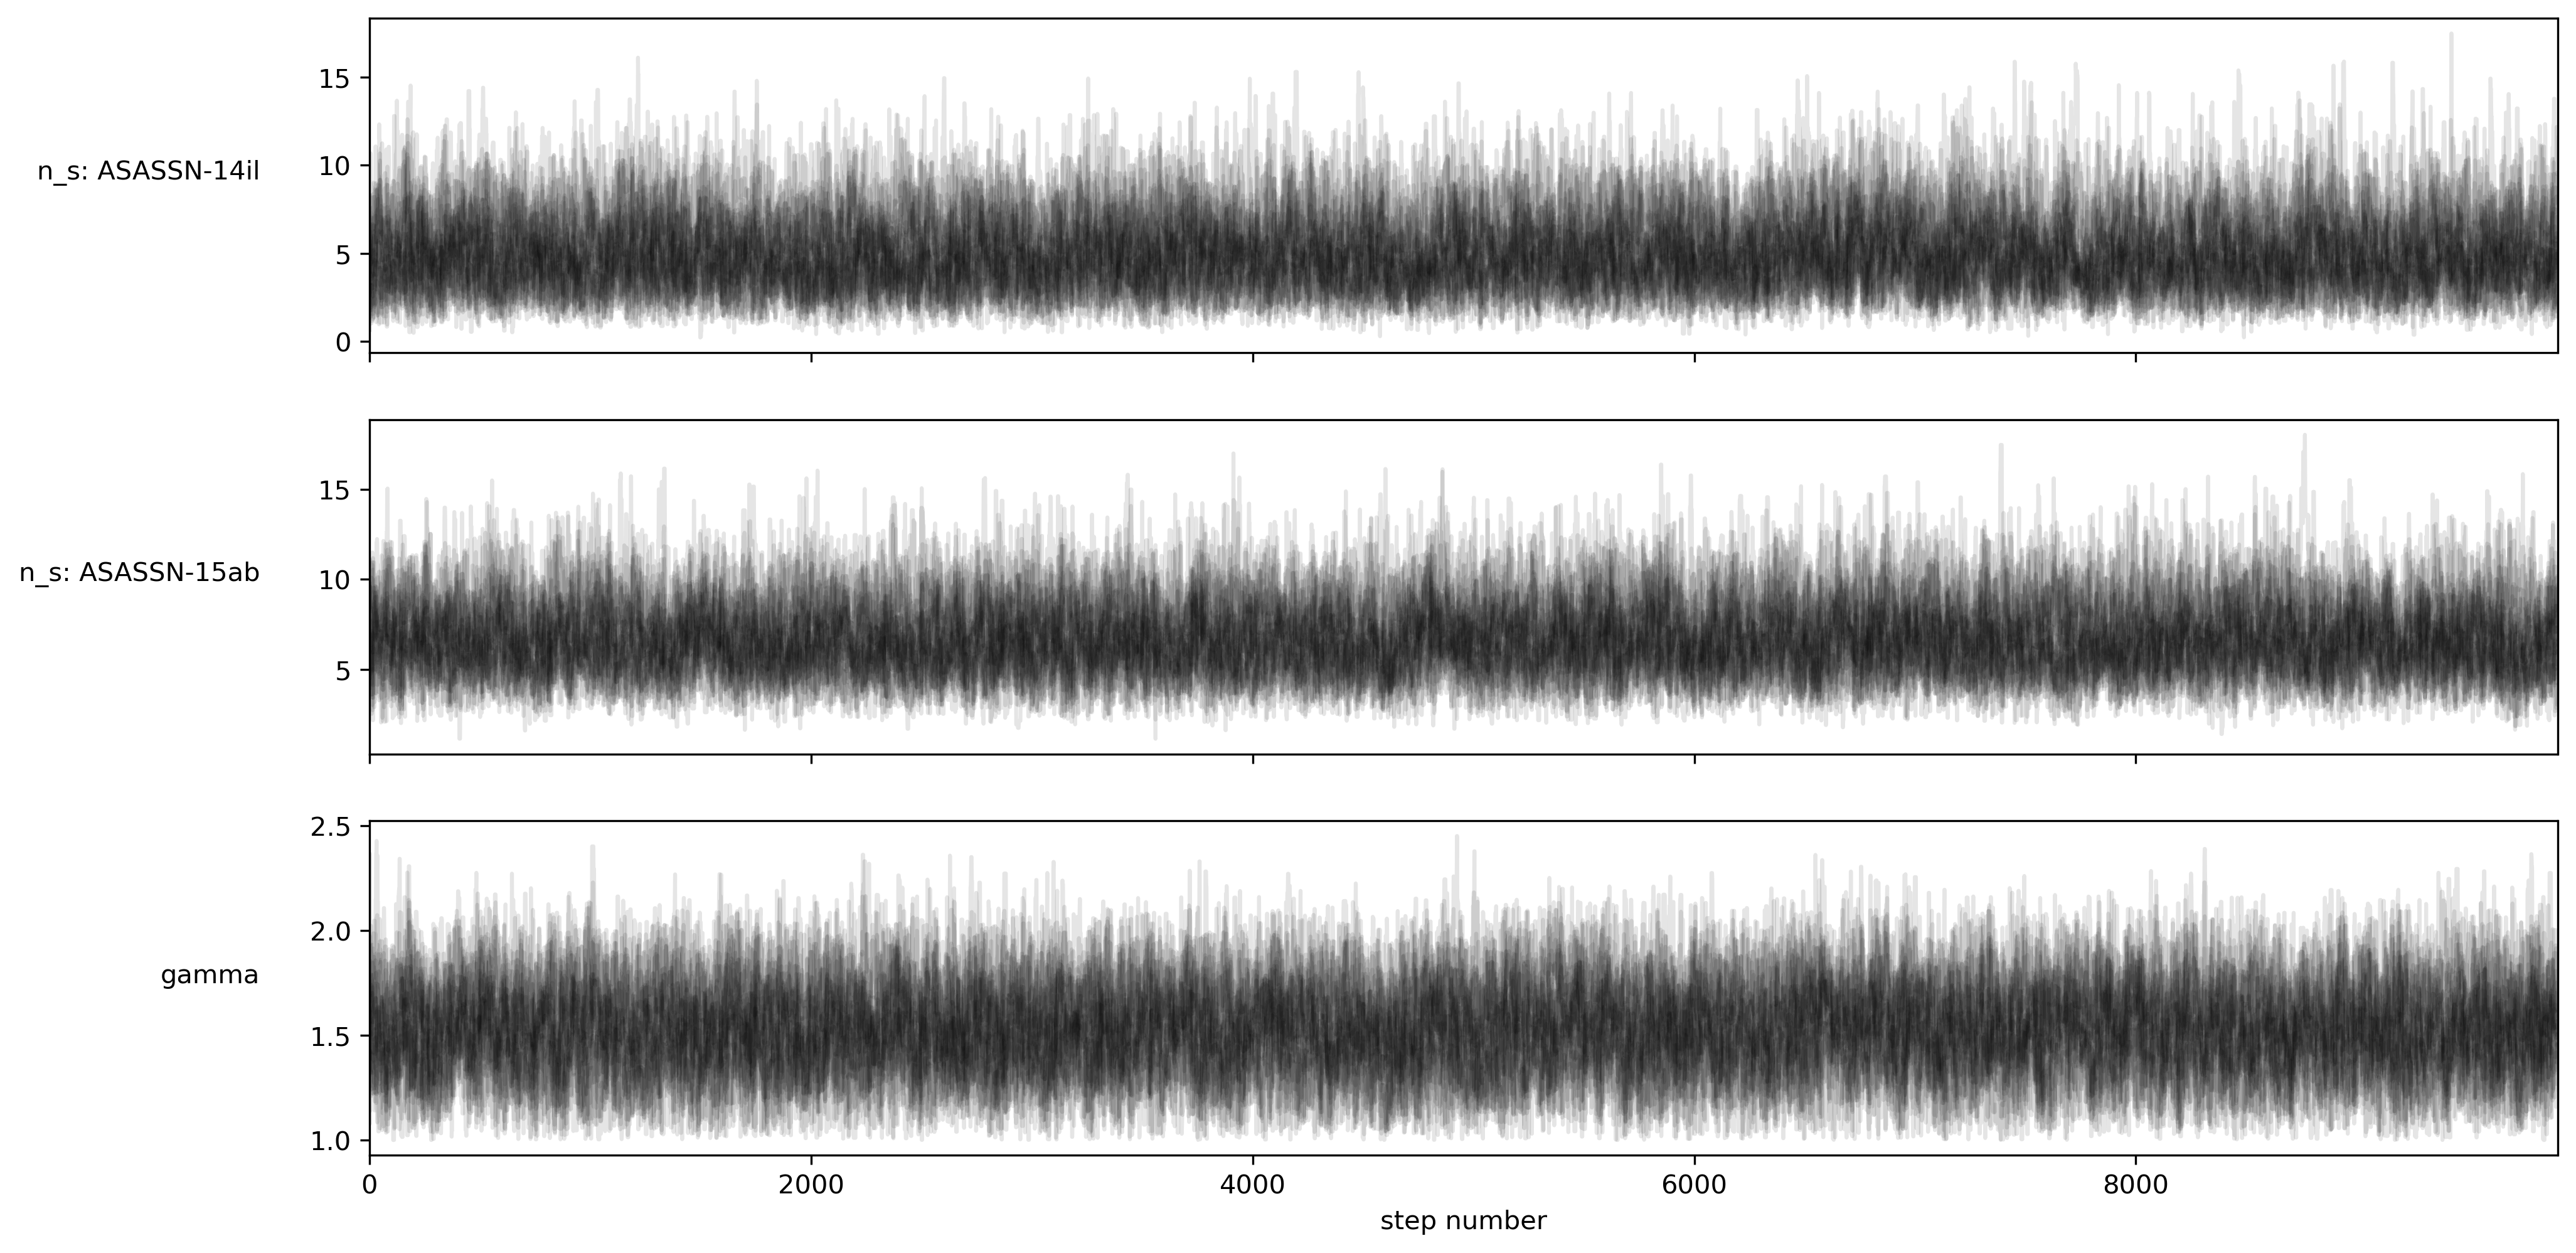

In [30]:
walker_plot(name, save_fig=True)